# FSDP In Jax NNX

If you find yourself with the daunting task of implementing production-level [FSDP](https://engineering.fb.com/2021/07/15/open-source/fsdp/) in JAX NNX, then this tutorial is for you. This notebook will guide you step by step through the process.

You will learn how to implement a fully working FSDP on TPU — with all critical operations JIT compiled — that evenly shards all weights across the devices together with DDP. Additionally, you will see how to use distributed checkpointing to save to/restore from disk or GCP bucket via Orbax, set up reproducible `nnx.Rngs` for noise generation and dropout, and maintain an EMA model that is also sharded.

Let's begin.

First, let's set some env variables. They will determine what packages we install.

In [ ]:
COLAB=True # Set this to False if you are running this notebook outside of Google Colab

Install Python dependencies based on the env variables above.

In [2]:
import sys
import subprocess

packages = ["jax[tpu]==0.5.1", "optax==0.2.4", "orbax-checkpoint==0.11.16", "flax==0.10.4"]
if not COLAB:
    packages += ["numpy==1.26.4", "torch==2.7.0", "matplotlib==3.10.3", "pillow==11.3.0", "gcsfs==2025.9.0"]
print(f"Installing {packages} ...")
subprocess.check_call([sys.executable, "-m", "pip", "install", *packages])

Installing ['jax[tpu]==0.5.1', 'optax==0.2.4', 'orbax-checkpoint==0.11.16', 'flax==0.10.4', 'numpy==1.26.4', 'torch==2.7.0', 'matplotlib==3.10.3', 'pillow==11.3.0', 'gcsfs==2025.9.0'] ...


0

In [3]:
import argparse
import functools
import logging
import os
from typing import Any, Generator, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import optax
import orbax.checkpoint as ocp
import torch
from flax import nnx
from jax import random
from jax.experimental import mesh_utils
from matplotlib.figure import Figure
from torch.utils.data import DataLoader, Dataset

Here, we define our hyperparameters and other variables we most likely would want to configure/adjust.

In [ ]:
args = argparse.Namespace(
    experiment_name="fsdp",
    gpu=False,
    steps=5_000,
    test_interval=1000,
    batch_size=256,
    log_interval=100,
    save_interval=2500,
    checkpoint_dir=os.path.abspath("checkpoints/"),
    output_dir=os.path.abspath("outputs/"),
    lr=1e-4,
    add_noise=False
)

Enabling INFO level logging.

In [5]:

log_format = "%(asctime)s - %(levelname)s - %(message)s"

logging.basicConfig(
    level=logging.INFO,
    format=log_format,
    handlers=[logging.StreamHandler()],
    force=True,
)

At the very beginning of our program, we need to initialize the JAX distributed framework.

In [6]:
jax.distributed.initialize()

INFO:2025-10-05 20:32:00,707:jax._src.distributed:130: Starting JAX distributed service on [::]:8476
2025-10-05 20:32:00,707 - INFO - Starting JAX distributed service on [::]:8476
INFO:2025-10-05 20:32:00,709:jax._src.distributed:147: Connecting to JAX distributed service on 10.202.0.129:8476
2025-10-05 20:32:00,709 - INFO - Connecting to JAX distributed service on 10.202.0.129:8476


Here you should see the devices available to you. In my case, it's 4 TPU chips.

In [7]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

Now let's define our JAX mesh and sharding axis. We only have one axis: `data`. We will use it for both the model and the data. This tells JAX to shard the model parameters across all devices in the mesh and also split the batch across all devices. Concretely, if you have `N` devices in your mesh, a single device stores `1/N` of the model weights and processes `1/N` of the global batch.

In [8]:
data_axis = "data"
device_mesh = mesh_utils.create_device_mesh(
    (jax.device_count(),), devices=jax.devices()
)
mesh = jax.sharding.Mesh(device_mesh, (data_axis,))

Here, we define two types of sharding. One that does sharding (along the `data` axis) and the other that doesn't, i.e., replication.

In [9]:
data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec(data_axis)
)
repl_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec()
)


In this tutorial, we will use a simple MLP as our model. It will learn a real number to a real number function mapping. It will also have a dropout layer to show how our implementation works with RNGs, which a real-world model would require.

In [10]:
IN_FEATURES = 1
OUT_FEATURES = 1
HIDDEN_DIM = 1024

In [11]:
class MLP(nnx.Module):
    """A Multi-Layer Perceptron (MLP) neural network using Flax NNX.

    This is a simple feedforward neural network with two hidden layers,
    ReLU activations, and dropout regularization.

    Args:
        din: Number of input features.
        dmid: Number of hidden units in each hidden layer.
        dout: Number of output features.
        rngs: Random number generators for parameter initialization and dropout.
    """

    def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs) -> None:
        """Initialize the MLP with specified dimensions.

        Args:
            din: Number of input features.
            dmid: Number of hidden units in each hidden layer.
            dout: Number of output features.
            rngs: Random number generators for parameter initialization and dropout.
        """
        self.fc1 = nnx.Linear(din, dmid, rngs=rngs)
        self.fc2 = nnx.Linear(dmid, dmid, rngs=rngs)
        self.dropout = nnx.Dropout(rate=0.1, rngs=rngs)
        self.fc3 = nnx.Linear(dmid, dout, rngs=rngs)
        self.rngs = rngs

    def __call__(self, x: jax.Array) -> jax.Array:
        """Forward pass through the MLP.

        Args:
            x: Input tensor of shape (batch_size, din).

        Returns:
            Output tensor of shape (batch_size, dout).
        """
        x = self.fc1(x)
        x = nnx.relu(x)
        x = self.fc2(x)
        x = nnx.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Many modern codebases have an EMA (Exponential Moving Average) model. We will have one as well to show how it fits into our FSDP JAX implementation. To initialize our EMA, we will clone our model state, replacing the weights with all zeros.

In [12]:
def init_ema(model: nnx.Module) -> nnx.State:
    """Initialize exponential moving average (EMA) state for a model.

    Creates a zero-initialized state tree with the same structure as the model's state.

    Args:
        model: The neural network model to create EMA state for.

    Returns:
        EMA state with the same structure as the model state, but zero-initialized.
    """
    ema_state = jax.tree.map(lambda x: jnp.zeros_like(x), nnx.state(model))
    return ema_state

This is the core initialization function where we initialize everything that we want to FSDP: the model, optimizer, and EMA.

In [13]:
def init(learning_rate: float) -> Tuple[nnx.GraphDef, nnx.State, nnx.State]:
    """Initialize the model, optimizer, and EMA state.

    Creates a new MLP model, wraps it in an AdamW optimizer, and initializes
    the exponential moving average state.

    Args:
        learning_rate: Learning rate for the AdamW optimizer.

    Returns:
        Tuple of (optimizer_graph, optimizer_state, ema_state).
    """
    model = MLP(
        IN_FEATURES,
        HIDDEN_DIM,
        OUT_FEATURES,
        rngs=nnx.Rngs(0, dropout=random.key(1), noise=random.key(2)),
    )
    opt = nnx.Optimizer(
        model,
        optax.adamw(learning_rate=learning_rate),
    )
    opt_graph, opt_state = nnx.split(opt)
    ema_state = init_ema(model)
    return opt_graph, opt_state, ema_state

It's convenient to have it as a function with no arguments because we will use `jax.eval_shape()` on it to figure out the shapes of the states we want to shard later.

In [14]:
init_fn = functools.partial(init, args.lr)
_, opt_state_shape, ema_state_shape = jax.eval_shape(init_fn)
logging.info(f"Opt state shape: {opt_state_shape}")
logging.info(f"EMA state shape: {ema_state_shape}")

2025-10-05 20:32:08,664 - INFO - Opt state shape: State({
  'model': {
    'dropout': {
      'rngs': {
        'default': {
          'count': VariableState( # 1 (4 B)
            type=RngCount,
            value=ShapeDtypeStruct(shape=(), dtype=uint32),
            tag='default'
          ),
          'key': VariableState( # 1 (8 B)
            type=RngKey,
            value=ShapeDtypeStruct(shape=(), dtype=key<fry>),
            tag='default'
          )
        },
        'dropout': {
          'count': VariableState( # 1 (4 B)
            type=RngCount,
            value=ShapeDtypeStruct(shape=(), dtype=uint32),
            tag='dropout'
          ),
          'key': VariableState( # 1 (8 B)
            type=RngKey,
            value=ShapeDtypeStruct(shape=(), dtype=key<fry>),
            tag='dropout'
          )
        },
        'noise': {
          'count': VariableState( # 1 (4 B)
            type=RngCount,
            value=ShapeDtypeStruct(shape=(), dtype=uint32),
        

As you can see, our EMA state has all the same parameters as the model that is stored inside the optimizer. The EMA state contains the rngs objects as well (more about it later).

The next three functions annotate the state shapes with sharding info based on your mesh. What that means is that it determines whether a weight should be sharded (only weights with the number of parameters >= `1024*1024` are sharded). If it should be sharded, it virtually splits it into shards and assigns them to devices. We will see what it looks like below.

In [15]:
def fsdp(
    axis: str,
    cur_spec: Tuple[Any, ...],
    mesh: jax.sharding.Mesh,
    var_state: nnx.VariableState,
    min_size_to_shard: int,
) -> Tuple[Any, ...]:
    """Implement Fully Sharded Data Parallel (FSDP) sharding strategy.

    Determines how to shard a parameter tensor across devices. Shards the largest
    dimension that is divisible by the number of devices and meets the minimum size requirement.

    Args:
        axis: Name of the mesh axis to shard along.
        cur_spec: Current partition specification.
        mesh: JAX device mesh.
        var_state: Variable state containing the parameter tensor.
        min_size_to_shard: Minimum tensor size to consider for sharding.

    Returns:
        Updated partition specification with sharding applied if appropriate.
    """
    arr = var_state.value
    if arr is None:
        return cur_spec
    shape = tuple(arr.shape)
    axis_size = mesh.shape[axis]
    if arr.size < min_size_to_shard:
        return cur_spec
    dim_indices = sorted(range(len(shape)), key=lambda i: shape[i], reverse=True)
    for i in dim_indices:
        if cur_spec[i] is None and shape[i] % axis_size == 0:
            new_spec = list(cur_spec)
            new_spec[i] = axis
            return tuple(new_spec)
    return cur_spec

def flatten_state(
    state: nnx.State, path: Tuple[str, ...] = ()
) -> Generator[Tuple[str, nnx.VariableState], None, None]:
    """Recursively flatten a nested state tree into (name, variable_state) pairs.

    Traverses the state tree and yields each variable with its hierarchical path name.

    Args:
        state: The state tree to flatten (can be nested).
        path: Current path in the hierarchy (used for recursion).

    Yields:
        Tuples of (path_name, variable_state) for each leaf variable.
    """
    if isinstance(state, nnx.VariableState):
        name = "/".join(str(p) for p in path)
        yield name, state
    elif hasattr(state, "items"):
        for key, subtree in state.items():
            yield from flatten_state(subtree, path + (key,))
    elif isinstance(state, (list, tuple)):
        for idx, subtree in enumerate(state):
            yield from flatten_state(subtree, path + (str(idx),))

def infer_sharding(
    state: nnx.State,
    mesh: jax.sharding.Mesh,
    axis: str,
    min_size_to_shard: int = 2**20,
) -> nnx.State:
    """Infer optimal sharding strategy for a model state using FSDP.

    Analyzes each parameter in the state and determines the best sharding strategy
    based on tensor size and dimensions. Creates a sharding tree that matches
    the structure of the input state.

    Args:
        state: Model state to create sharding for.
        mesh: JAX device mesh for distributed computation.
        axis: Name of the mesh axis for sharding.
        min_size_to_shard: Minimum tensor size to consider for sharding.

    Returns:
        Sharding tree with the same structure as the input state.
    """
    flat_params = list(flatten_state(state))
    vars_states = [vs for _, vs in flat_params]

    specs = [
        (None,) * vs.value.ndim if vs.value is not None else () for vs in vars_states
    ]

    for i, _ in enumerate(flat_params):
        specs[i] = fsdp(axis, specs[i], mesh, vars_states[i], min_size_to_shard)

    shardings = [
        jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec(*spec))
        for spec in specs
    ]

    sharding_tree = jax.tree_util.tree_unflatten(
        jax.tree_util.tree_structure(
            state, is_leaf=lambda x: isinstance(x, nnx.VariableState)
        ),
        shardings,
    )
    return sharding_tree

Here, we call the top-level function `infer_sharding()` to get the state sharding objects.

In [16]:
opt_state_sharding = infer_sharding(opt_state_shape, mesh, data_axis)
ema_state_sharding = infer_sharding(ema_state_shape, mesh, data_axis)
logging.info(f"Opt state sharding: {opt_state_sharding}")
logging.info(f"EMA state sharding: {ema_state_sharding}")

2025-10-05 20:32:08,680 - INFO - Opt state sharding: State({
  'model': {
    'dropout': {
      'rngs': {
        'default': {
          'count': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(), memory_kind=device),
          'key': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(), memory_kind=device)
        },
        'dropout': {
          'count': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(), memory_kind=device),
          'key': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(), memory_kind=device)
        },
        'noise': {
          'count': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(), memory_kind=device),
          'key': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(), memory_kind=device)
        }
      }
    },
    'fc1': {
      'bias': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(None,), memory_kind=device),
      'kernel': NamedSharding(mesh=Mesh('data': 4), spec=PartitionSpec(None, None), memory_kind

As you can see, all weights except for the kernel in `fc1` have `PartitionSpec(None, None)` assigned to them. It means they won't be sharded. This is what we want because their sizes are < `1024*1024`. Only the kernel in `fc1`, which maps from `1024` to `1024`, passed the threshold and has `PartitionSpec('data', None)` assigned to it. It means that its weights array of shape `(1024, 1024)` will be sharded on the first dimension along the `data` sharding axis. The second dimension won't be sharded because it's enough to just shard across one dimension to ensure all parameters are evenly distributed across the devices.

Now it's time to materialize our NNX modules on all our devices. The `jax.jit()` wrapper is crucial here because it lets JAX first trace our objects according to their state shardings and then, when the function is actually executed, the objects materialize on the corresponding devices. This ensures your entire state never materializes on a single device. Without the wrapper, JAX would first materialize the objects on a single device and then shard them, and if your model doesn't fit into a single device, the program will OOM at this point.

In [17]:
opt_graph, opt_state, ema_state = jax.jit(
    init_fn,
    out_shardings=(repl_sharding, opt_state_sharding, ema_state_sharding),
)()

Let's define a helper debug logging function to see what our sharded states look like in more detail.

In [18]:
def log_shard_map(tag: str, state: nnx.State) -> None:
    """Log the sharding mapping of arrays to devices for debugging.

    Prints a detailed breakdown of how each parameter is sharded across devices,
    showing which array indices are stored on which devices.

    Args:
        tag: Descriptive tag for the logging output.
        state: Model state to analyze for sharding information.
    """
    logging.info(f"── Shard ↦ device map: {tag} ──")

    for name, var in flatten_state(state):
        arr = var.value if isinstance(var, nnx.VariableState) else var
        for d, idx in arr.sharding.devices_indices_map(arr.shape).items():
            logging.info(f" {name}  {idx}  → {d}")

if jax.process_index() == 0:
    log_shard_map("Opt state sharding", opt_state)
    log_shard_map("EMA state sharding", ema_state)

2025-10-05 20:32:09,510 - INFO - ── Shard ↦ device map: Opt state sharding ──
2025-10-05 20:32:09,510 - INFO -  model/dropout/rngs/default/count  ()  → TPU_0(process=0,(0,0,0,0))
2025-10-05 20:32:09,511 - INFO -  model/dropout/rngs/default/count  ()  → TPU_2(process=0,(0,1,0,0))
2025-10-05 20:32:09,511 - INFO -  model/dropout/rngs/default/count  ()  → TPU_1(process=0,(1,0,0,0))
2025-10-05 20:32:09,511 - INFO -  model/dropout/rngs/default/count  ()  → TPU_3(process=0,(1,1,0,0))
2025-10-05 20:32:09,512 - INFO -  model/dropout/rngs/default/key  ()  → TPU_0(process=0,(0,0,0,0))
2025-10-05 20:32:09,512 - INFO -  model/dropout/rngs/default/key  ()  → TPU_2(process=0,(0,1,0,0))
2025-10-05 20:32:09,512 - INFO -  model/dropout/rngs/default/key  ()  → TPU_1(process=0,(1,0,0,0))
2025-10-05 20:32:09,512 - INFO -  model/dropout/rngs/default/key  ()  → TPU_3(process=0,(1,1,0,0))
2025-10-05 20:32:09,513 - INFO -  model/dropout/rngs/dropout/count  ()  → TPU_0(process=0,(0,0,0,0))
2025-10-05 20:32:09,5

As you can see, our `fc2/kernel` weights get a partial slice on each device, whereas all other weights have the full slice on all devices.

Through some NNX model surgery, we define two graphs for our model: train and eval, which we will later use for training and testing, respectively.

`train()` and `eval()` only change your graph (static information of your model). It does change the states.

It's also worth noting that we store our models (NNX modules) as a separate graph and state at the global program level instead of a single module and only merge them right before we need to do a JAX operation on them. I find it's easier to think about and manage your models as two separate objects: graph (static) and state (dynamic) at all other times.

In [19]:
opt = nnx.merge(opt_graph, opt_state)
opt.model.train()
opt_graph, opt_state = nnx.split(opt)
opt.model.eval()
model_graph_eval, _ = nnx.split(opt.model)

Here we are initializing our distributed Orbax checkpointer.

In [20]:
ckpt_mngr = ocp.CheckpointManager(
    args.checkpoint_dir,
    options=ocp.CheckpointManagerOptions(
        save_interval_steps=args.save_interval,
        max_to_keep=2,
        step_prefix=args.experiment_name,
        enable_async_checkpointing=False,
    ),
)

2025-10-05 20:32:09,563 - INFO - [thread=MainThread] Failed to get flag value for EXPERIMENTAL_ORBAX_USE_DISTRIBUTED_PROCESS_ID.
2025-10-05 20:32:09,564 - INFO - [process=0][thread=MainThread] CheckpointManager init: checkpointers=None, item_names=None, item_handlers=None, handler_registry=None
2025-10-05 20:32:09,564 - INFO - Initialized registry DefaultCheckpointHandlerRegistry({('metrics', <class 'orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonSaveArgs'>): <orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonCheckpointHandler object at 0x7f16887108c0>, ('metrics', <class 'orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonRestoreArgs'>): <orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonCheckpointHandler object at 0x7f16887108c0>}).
2025-10-05 20:32:09,565 - INFO - orbax-checkpoint version: 0.11.16
2025-10-05 20:32:09,565 - INFO - [process=0] Created OpTracker for checkpoint_manager_save with operation id 1
2025-10-05 20:32:09,819 - INFO - Create

For this tutorial, we will use a simple dataset that represents X and Y of the sinusoidal function. This is the function our model will learn to map.

In [21]:
class SinDataset(Dataset):
    """A PyTorch dataset that generates sine function data points.

    This dataset generates random x values from [-π, π] and computes y = sin(x).
    The dataset uses a seeded random number generator for reproducible results.

    Args:
        seed: Random seed for reproducible data generation.
    """

    def __init__(self, seed: int) -> None:
        """Initialize the dataset with a random seed.

        Args:
            seed: Random seed for data generation.
        """
        self.seed = seed
        self.reset_seed()

    def reset_seed(self) -> None:
        """Reset the random number generator to the initial seed.

        This is useful for ensuring reproducible evaluation data.
        """
        self.rng = torch.Generator()
        self.rng.manual_seed(self.seed)

    def __len__(self) -> int:
        """Return the length of the dataset.

        Returns:
            A very large number representing the dataset size.
        """
        return 2**31 - 1

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Generate a single data point.

        Args:
            idx: Index (unused, but required for Dataset interface).

        Returns:
            Tuple of (x, y) where x is a random value in [-π, π] and y = sin(x).
        """
        x = torch.rand(1, generator=self.rng) * 2 * torch.pi - torch.pi
        y = torch.sin(x)
        return x.numpy(), y.numpy()

Converting our global batch size (across all JAX processes and devices) to a local batch size: the number of samples processed by the current JAX/Python process. This should not be confused with the per device/chip batch size because a single JAX process usually has more than one device assigned.

In [22]:
local_batch_size = args.batch_size // jax.process_count()

We are getting close to the training code. Below, we define our `train_step()` function. It merges the graph and state of our optimizer into an NNX module, passes a batch through it, computes the loss, and updates the parameters with the gradients.

It's important to understand that `x` and `y` in this function are global arrays. Their first dimension, batch dimension, is equal to the global batch size. All aggregate operations we run on them, like `.mean()`, run across the entire global array.

The function also optionally adds noise to the data. This doesn't make much sense in our example problem, but working with noise is essential in some real-world models like diffusion models. It requires drawing from an RNG generator, and I added it here to show how our code supports it. The random values we sample are also global and don't repeat across JAX processes/devices. To see how our model handles the noise, set `args.add_noise=True`.

In [23]:

def train_step(
    opt_graph: nnx.GraphDef,
    opt_state: nnx.State,
    x: jax.Array,
    y: jax.Array,
    add_noise: bool = False,
) -> Tuple[nnx.State, jax.Array]:
    """Perform a single training step with gradient computation and parameter update.

    Computes the forward pass, loss, gradients, and updates model parameters.
    Optionally adds noise to the target values for data augmentation.

    Args:
        opt_graph: Optimizer graph definition (static structure).
        opt_state: Optimizer state (parameters and optimizer state).
        x: Input batch of shape (batch_size, input_dim).
        y: Target batch of shape (batch_size, output_dim).
        add_noise: Whether to add noise to targets for data augmentation.

    Returns:
        Tuple of (updated_optimizer_state, loss_value).
    """
    optimizer = nnx.merge(opt_graph, opt_state)
    model = optimizer.model

    def loss_fn(model: MLP) -> jax.Array:
        y_hat = model(x)
        if add_noise:
            noise_key = model.rngs["noise"]()
            noise = jax.random.normal(noise_key, y.shape)
            y_noisy = y + noise
            loss = jnp.mean((y_hat - y_noisy) ** 2)
        else:
            loss = jnp.mean((y_hat - y) ** 2)
        return loss

    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model)
    optimizer.update(grads)

    _, opt_state = nnx.split(optimizer)

    return opt_state, loss


Now we can wrap our `train_step()` function in the `jax.jit()` decorator for JAX to compile into an optimized XLA code that will be executed on the cluster of our devices. It's important to mark all non JAX array args as static. Additionally, to save memory, we tell JAX with `donate_argnums` that the argument with index `1` is also returned, and it can reuse the underlying memory buffer. Lastly, we mark that we expect our first output to be sharded because it's our updated optimizer state, and the second to be replicated because it's the loss as a scalar.

In [24]:
train_step_fn = jax.jit(
    train_step,
    donate_argnums=(1,),
    static_argnums=(4,),
    out_shardings=(opt_state_sharding, repl_sharding),
)

Below, we define our test function, which works very similarly to the `train_step()` function, except it doesn't update the parameters.

In [25]:
def test_step(
    model_graph: nnx.GraphDef,
    model_state: nnx.State,
    x: jax.Array,
    y: jax.Array,
) -> Tuple[jax.Array, jax.Array]:
    """Perform a single evaluation step without parameter updates.

    Computes the forward pass and loss for evaluation purposes.

    Args:
        model_graph: Model graph definition (static structure).
        model_state: Model state (parameters only, no optimizer state).
        x: Input batch of shape (batch_size, input_dim).
        y: Target batch of shape (batch_size, output_dim).

    Returns:
        Tuple of (loss_value, predictions).
    """
    model = nnx.merge(model_graph, model_state)
    y_hat = model(x)
    loss = jnp.mean((y_hat - y) ** 2)
    return loss, y_hat

In [26]:
test_step_fn = jax.jit(
    test_step,
    out_shardings=(repl_sharding, data_sharding),
)

Here is our function to manage the EMA model. It updates all parameters in the EMA version using the `ema_decay` constant.

In [27]:
def update_ema(
    model_state: nnx.State,
    ema_state: nnx.State,
    ema_decay: float,
) -> nnx.State:
    """Update exponential moving average (EMA) of model parameters.

    Computes the exponential moving average using the formula:
    ema_new = ema_decay * ema_old + (1 - ema_decay) * model_param

    Args:
        model_state: Current model state with updated parameters.
        ema_state: Current EMA state to be updated.
        ema_decay: Decay factor for EMA (typically close to 1.0, e.g., 0.9999).

    Returns:
        Updated EMA state.
    """

    def update_param(p_model: jax.Array, p_ema: jax.Array) -> jax.Array:
        return p_ema * ema_decay + p_model * (1 - ema_decay)

    ema_state_no_rng = jax.tree.map(
        update_param,
        nnx.filter_state(model_state, nnx.Param),
        nnx.filter_state(ema_state, nnx.Param),
    )
    ema_state = nnx.merge_state(ema_state, ema_state_no_rng)
    return ema_state

In [28]:
update_ema_fn = jax.jit(
    update_ema,
    out_shardings=ema_state_sharding,
    donate_argnums=(1,),
)

This function is an essential DDP function. Our JAX cluster consists of several JAX/Python processes. Each of them loads `local_batch_size` samples. However, as we saw before, our `train_step()` and `test_step()` functions expect global arrays with a global batch size. That's what this function does. It takes local arrays/batches and builds them into a global, sharded array where the data from local batches is put into shards on the local devices.

In [29]:
def make_fsarray_from_local_slice(
    local_slice: jnp.ndarray,
    global_devices: list[jax.Device],
    axis: str,
) -> jax.Array:
    """Create a globally sharded array from a local data slice.

    Takes a local data slice and creates a globally sharded JAX array
    by distributing the data across multiple devices and processes.

    This function is adapted from:
    https://github.com/google-research/big_vision/blob/0127fb6b337ee2a27bf4e54dea79cff176527356/big_vision/utils.py#L1388-L1409

    Args:
        local_slice: Local portion of the data on this process.
        global_devices: List of all devices across all processes.
        axis: Name of the axis for sharding.

    Returns:
        Globally sharded JAX array with proper device placement.
    """
    mesh = jax.sharding.Mesh(global_devices, (axis,))
    sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec(axis))
    local_ds = mesh.local_devices

    x = np.asarray(local_slice)
    xs = jax.device_put(np.split(x, len(local_ds), axis=0), local_ds)

    global_shape = (x.shape[0] * jax.process_count(), *x.shape[1:])
    return jax.make_array_from_single_device_arrays(global_shape, sharding, xs)

Finally training. We define our training loop as a function because we will want to reuse it later.

It takes in a start step number and states, initializes dataloaders, trains, and evaluates our model according to the hyperparameters in `args`.

As you can see, we call `make_fsarray_from_local_slice()` on the local batch that the dataloader returns before supplying it to `train_step()` and `test_step()`.

We update our EMA model after every train step and periodically checkpoint our states to disk and run eval. The `jax.experimental.multihost_utils.process_allgather()` we call on our global array before visualizing is needed to tell JAX to bring these arrays to the host memory so we can do numpy operations on it.

At least by the time of writing this, Orbax didn't have a straightforward way of saving the `NNX.Rngs` object in the checkpoint. That's why we need to filter out the rngs from the state and save them separately as a standard JAX array. We do this for EMA as well, because we will later need its rng object to restore the full EMA, but it's worth noting that the rng object inside the EMA never gets drawn, so it stays in its initial, zero state.

In [30]:
def train_loop(start_step: int, opt_state: nnx.State, ema_state: nnx.State):
  train_dataloader = DataLoader(
    SinDataset(seed=start_step), batch_size=local_batch_size, shuffle=False
  )
  test_dataset = SinDataset(seed=-1)
  test_dataloader = DataLoader(
      test_dataset, batch_size=local_batch_size, shuffle=False
  )



  train_iter = iter(train_dataloader)
  ema_decay = 0.999

  for step in range(start_step, start_step + args.steps):
      x_batch, y_batch = next(train_iter)
      x_batch = make_fsarray_from_local_slice(
          x_batch, mesh.devices.flatten(), data_axis
      )
      y_batch = make_fsarray_from_local_slice(
          y_batch, mesh.devices.flatten(), data_axis
      )

      opt_state, train_loss = train_step_fn(
          opt_graph, opt_state, x_batch, y_batch, args.add_noise
      )

      ema_state = update_ema_fn(opt_state["model"], ema_state, ema_decay)

      if jax.process_index() == 0 and (step + 1) % args.log_interval == 0:
          logging.info(f"Step {step+1}, Train Loss: {train_loss:.6f}")

      if (step + 1) % args.test_interval == 0:
          test_dataset.reset_seed()
          test_iter = iter(test_dataloader)
          x_test, y_test = next(test_iter)
          x_test = make_fsarray_from_local_slice(
              x_test, mesh.devices.flatten(), data_axis
          )
          y_test = make_fsarray_from_local_slice(
              y_test, mesh.devices.flatten(), data_axis
          )
          test_loss, y_pred_model = test_step_fn(
              model_graph_eval, opt_state["model"], x_test, y_test
          )

          test_loss_ema, y_pred_ema = test_step_fn(
              model_graph_eval, ema_state, x_test, y_test
          )

          y_pred_model = jax.experimental.multihost_utils.process_allgather(
              y_pred_model, tiled=True
          )
          y_pred_ema = jax.experimental.multihost_utils.process_allgather(
              y_pred_ema, tiled=True
          )
          x_test = jax.experimental.multihost_utils.process_allgather(
              x_test, tiled=True
          )
          y_test = jax.experimental.multihost_utils.process_allgather(
              y_test, tiled=True
          )

          if jax.process_index() == 0:
              x_plot = np.array(x_test).flatten()
              y_true_plot = np.array(y_test).flatten()
              y_pred_ema_plot = np.array(y_pred_ema).flatten()
              y_pred_model_plot = np.array(y_pred_model).flatten()

              sort_idx = np.argsort(x_plot)
              x_plot = x_plot[sort_idx]
              y_true_plot = y_true_plot[sort_idx]
              y_pred_ema_plot = y_pred_ema_plot[sort_idx]
              y_pred_model_plot = y_pred_model_plot[sort_idx]

              experiment_output_dir = os.path.join(
                  args.output_dir, args.experiment_name
              )
              os.makedirs(experiment_output_dir, exist_ok=True)
              fig = Figure(figsize=(10, 6))
              ax = fig.add_subplot(111)
              ax.scatter(x_plot, y_true_plot, alpha=0.7, label="Ground Truth", s=20)
              ax.scatter(
                  x_plot,
                  y_pred_model_plot,
                  alpha=0.7,
                  label="Model Prediction",
                  s=20,
              )
              ax.scatter(
                  x_plot,
                  y_pred_ema_plot,
                  alpha=0.7,
                  label="EMA Prediction",
                  s=20,
              )
              ax.set_xlabel("X")
              ax.set_ylabel("Y")
              ax.set_title("Sin Function: Ground Truth vs Model vs EMA Prediction")
              ax.legend()
              ax.grid(True, alpha=0.3)

              plot_path = os.path.join(experiment_output_dir, f"eval_{step+1}.png")
              fig.savefig(plot_path, dpi=300, bbox_inches="tight")

              logging.info(f"Plot saved to {plot_path}")

              if jax.process_index() == 0:
                  logging.info(
                      f"Step {step+1}, Test Loss: {test_loss:.6f}, "
                      f"EMA Test Loss: {test_loss_ema:.6f}"
                  )

      if (step + 1) % args.save_interval == 0:
          if jax.process_index() == 0:
              logging.info(f"Saving checkpoint at step {step + 1}")
          opt_rngs, opt_state_no_rngs = nnx.filter_state(opt_state, nnx.RngKey, ...)
          opt_rng_keys = jax.tree.map(jax.random.key_data, opt_rngs)

          ema_rngs, ema_state_no_rngs = nnx.filter_state(ema_state, nnx.RngKey, ...)
          ema_rng_keys = jax.tree.map(jax.random.key_data, ema_rngs)
          ckpt_mngr.save(
              step + 1,
              args=ocp.args.Composite(
                  opt_state=ocp.args.StandardSave(opt_state_no_rngs),
                  opt_rngs=ocp.args.StandardSave(opt_rng_keys),
                  ema_state=ocp.args.StandardSave(ema_state_no_rngs),
                  ema_rngs=ocp.args.StandardSave(ema_rng_keys),
              ),
          )
          if jax.process_index() == 0:
              logging.info(f"Checkpoint saved successfully")



Let's train our model!

In [31]:
start_step = 0
train_loop(start_step, opt_state, ema_state)

2025-10-05 20:32:12,456 - INFO - Step 100, Train Loss: 0.232647
2025-10-05 20:32:13,548 - INFO - Step 200, Train Loss: 0.178514
2025-10-05 20:32:14,642 - INFO - Step 300, Train Loss: 0.137890
2025-10-05 20:32:15,734 - INFO - Step 400, Train Loss: 0.103556
2025-10-05 20:32:16,828 - INFO - Step 500, Train Loss: 0.071781
2025-10-05 20:32:17,921 - INFO - Step 600, Train Loss: 0.064227
2025-10-05 20:32:19,014 - INFO - Step 700, Train Loss: 0.038317
2025-10-05 20:32:20,155 - INFO - Step 800, Train Loss: 0.031034
2025-10-05 20:32:21,256 - INFO - Step 900, Train Loss: 0.018365
2025-10-05 20:32:22,357 - INFO - Step 1000, Train Loss: 0.011609
2025-10-05 20:32:22,900 - INFO - Plot saved to /home/georgy/fsdp-in-jax-nnx/outputs/fsdp/eval_1000.png
2025-10-05 20:32:22,901 - INFO - Step 1000, Test Loss: 0.010148, EMA Test Loss: 0.306501
2025-10-05 20:32:24,108 - INFO - Step 1100, Train Loss: 0.007852
2025-10-05 20:32:25,202 - INFO - Step 1200, Train Loss: 0.007552
2025-10-05 20:32:26,299 - INFO - Step

Our model has been trained. You can see in the logs above that its test loss is pretty low. Also, check the eval images. The predicted graph should look just like the sinusoidal function.

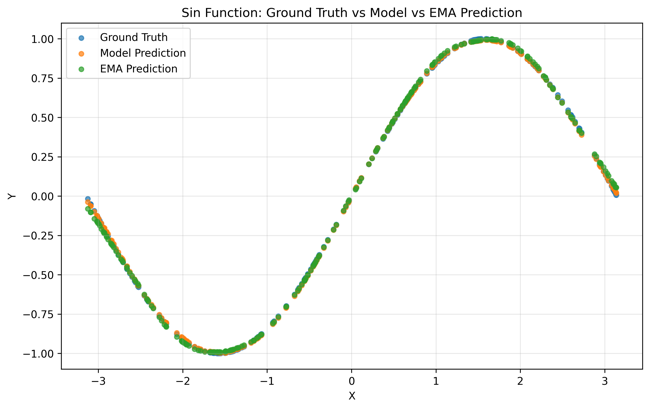

In [32]:
import os
import glob
from PIL import Image 

exp_dir = os.path.join(args.output_dir, args.experiment_name)
png_files = glob.glob(os.path.join(exp_dir, "*.png"))
latest_png = max(png_files, key=os.path.getmtime)
img=Image.open(latest_png)
resized_img = img.resize((img.width // 4, img.height // 4))
resized_img

Let's now simulate the situation when you want to load a trained model. This is usually done to either evaluate or resume training.

In our case, we will load the previously trained model from disk and run our training loop on it again.

Since JAX is built on functional programming and we never returned the trained states from our first `train_loop()` call, our global `opt_state` and `ema_state` variables contain the initial, randomly initialized networks. It's as if we started our program anew, with the difference that we first load an existing model from disk using Orbax.

As we did when we were saving the checkpoints, we filter out the rngs so that the type and shape of what we ask to restore matches what was saved. The cool thing is that since our states have been marked with sharding, Orbax ensures the state will never get materialized on a single device, but get sharded accordingly. Additionally, Orbax will disregard the sharding information of the states saved on disk and load it according to our current sharding. This allows us to first train a model on one cluster configuration and then load it in another cluster. Note that for this behavior to work, you need to use `ocp.args.StandardRestore()` and not `ocp.args.PyTreeRestore()`.

After loading the states and rngs separately, we merge them. You can examine the values inside the rngs dropout object. It says `Array(5000, dtype=uint32)`, which should match the number of training steps we have done in our model, so we are resuming from the same rng sequence. The dropout rng value in the EMA is `Array(0, dtype=uint32)` because it was never drawn.

In [33]:
latest_step = args.steps

opt_rngs, opt_state_no_rngs = nnx.filter_state(opt_state, nnx.RngKey, ...)
opt_rng_keys = jax.tree.map(jax.random.key_data, opt_rngs)

ema_rngs, ema_state_no_rngs = nnx.filter_state(ema_state, nnx.RngKey, ...)
ema_rng_keys = jax.tree.map(jax.random.key_data, ema_rngs)

state_restored = ckpt_mngr.restore(
    latest_step,
    args=ocp.args.Composite(
        opt_state=ocp.args.StandardRestore(opt_state_no_rngs),
        ema_state=ocp.args.StandardRestore(ema_state_no_rngs),
        opt_rngs=ocp.args.StandardRestore(opt_rng_keys),
        ema_rngs=ocp.args.StandardRestore(ema_rng_keys),
    ),
)
opt_state_no_rngs, ema_state_no_rngs, opt_rngs_keys, ema_rngs_keys = (
    state_restored.opt_state,
    state_restored.ema_state,
    state_restored.opt_rngs,
    state_restored.ema_rngs,
)
opt_rngs = jax.tree_map(jax.random.wrap_key_data, opt_rngs_keys)
ema_rngs = jax.tree_map(jax.random.wrap_key_data, ema_rngs_keys)
opt_state = nnx.merge_state(opt_state_no_rngs, opt_rngs)
ema_state = nnx.merge_state(ema_state_no_rngs, ema_rngs)
if jax.process_index() == 0:
    logging.info("Checkpoint restored successfully")
    log_shard_map("Opt state sharding after restore", opt_state)
    log_shard_map("EMA state sharding after restore", ema_state)
    logging.info(f"Opt state after restore: {opt_state}")
    logging.info(f"EMA state after restore: {ema_state}")


2025-10-05 20:33:16,340 - INFO - Restoring checkpoint from gs://solaris-east5/georgy/fsdp-jax/checkpoints/fsdp_5000.


2025-10-05 20:33:16,575 - INFO - [process=0] /jax/checkpoint/read/bytes_per_sec: 619 Bytes/s (total bytes: 96 Bytes) (time elapsed: 154 milliseconds) (per-host)
2025-10-05 20:33:16,817 - INFO - [process=0] /jax/checkpoint/read/bytes_per_sec: 24.0 MiB/s (total bytes: 4.1 MiB) (time elapsed: 169 milliseconds) (per-host)
2025-10-05 20:33:17,026 - INFO - [process=0] /jax/checkpoint/read/bytes_per_sec: 666 Bytes/s (total bytes: 96 Bytes) (time elapsed: 144 milliseconds) (per-host)
2025-10-05 20:33:17,335 - INFO - [process=0] /jax/checkpoint/read/bytes_per_sec: 51.8 MiB/s (total bytes: 12.2 MiB) (time elapsed: 235 milliseconds) (per-host)
2025-10-05 20:33:17,335 - INFO - Finished restoring checkpoint in 1.12 seconds from gs://solaris-east5/georgy/fsdp-jax/checkpoints/fsdp_5000.
2025-10-05 20:33:17,335 - INFO - {'step': 5000, 'event_type': 'restore', 'directory': 'gs://solaris-east5/georgy/fsdp-jax/checkpoints', 'checkpointer_start_time': 1759696396.2143493, 'checkpointer_duration_secs': 1.12

Now we run `train_loop()` once again using the states we just loaded and starting from the last step.

In [34]:
start_step = latest_step
train_loop(start_step, opt_state, ema_state)

2025-10-05 20:33:18,505 - INFO - Step 5100, Train Loss: 0.000881
2025-10-05 20:33:19,607 - INFO - Step 5200, Train Loss: 0.001370
2025-10-05 20:33:20,711 - INFO - Step 5300, Train Loss: 0.000773
2025-10-05 20:33:21,810 - INFO - Step 5400, Train Loss: 0.004323
2025-10-05 20:33:22,912 - INFO - Step 5500, Train Loss: 0.001996
2025-10-05 20:33:24,012 - INFO - Step 5600, Train Loss: 0.002029
2025-10-05 20:33:25,284 - INFO - Step 5700, Train Loss: 0.003011
2025-10-05 20:33:26,391 - INFO - Step 5800, Train Loss: 0.000485
2025-10-05 20:33:27,494 - INFO - Step 5900, Train Loss: 0.000653
2025-10-05 20:33:28,596 - INFO - Step 6000, Train Loss: 0.000697
2025-10-05 20:33:28,982 - INFO - Plot saved to /home/georgy/fsdp-in-jax-nnx/outputs/fsdp/eval_6000.png
2025-10-05 20:33:28,983 - INFO - Step 6000, Test Loss: 0.000865, EMA Test Loss: 0.000275
2025-10-05 20:33:30,091 - INFO - Step 6100, Train Loss: 0.001780
2025-10-05 20:33:31,201 - INFO - Step 6200, Train Loss: 0.000800
2025-10-05 20:33:32,310 - IN

That's it. Our model has trained for another `5000` steps.

As a final note, I wanted to share some JAX findings I discovered through my work with it that might be helpful to whoever is reading this.

When you call JITed functions, like we do with `train_step_fn()` inside our `train_loop()` function, JAX launches it asynchronously, so your host Python code continues right away. This makes JAX  run as much in parallel as possible. JAX will synchronize everything later when your next JAX function requires the output of the previous function. This means that if you want to measure the execution time of your `train_step_fn()` and do `time.time()` before it and after, you will see an unrealistically small number. To make your measurement legit, you need to tell JAX to block for the output with `jax.block_until_ready(opt_state)` before you make your second time observation. However, this should only be done for temporary debugging, and your production code should not have any `block_until_ready()` in our training loop because it breaks the internal JAX parallelization and makes your training loop run slower overall.

You cannot do `logging.into()` or `print()` inside your JITed functions because they don't run in Python. To print some debugging info, you need to use `jax.debug.print()` instead. However, there are two things to note. First, if your function fails somewhere after the print and never finishes, you won't see that print. The JITed function needs to finish for you to see all of its prints. Second, having any `jax.debug.*` function calls in your JITed function slows down its execution significantly. Make sure they never make it into your production code.

This concludes our JAX FSDP tutorial. I hope it was useful. Happy JAXing!